# ARL Compare


In [1]:
from exp import *


In [2]:
# pip install --upgrade efficientnet-pytorch


## Load the dataset

In [2]:
dm = DatasetManager('2017',224,'all','2017')

In [3]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=0.3,p_affine=1, max_warp=0)
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

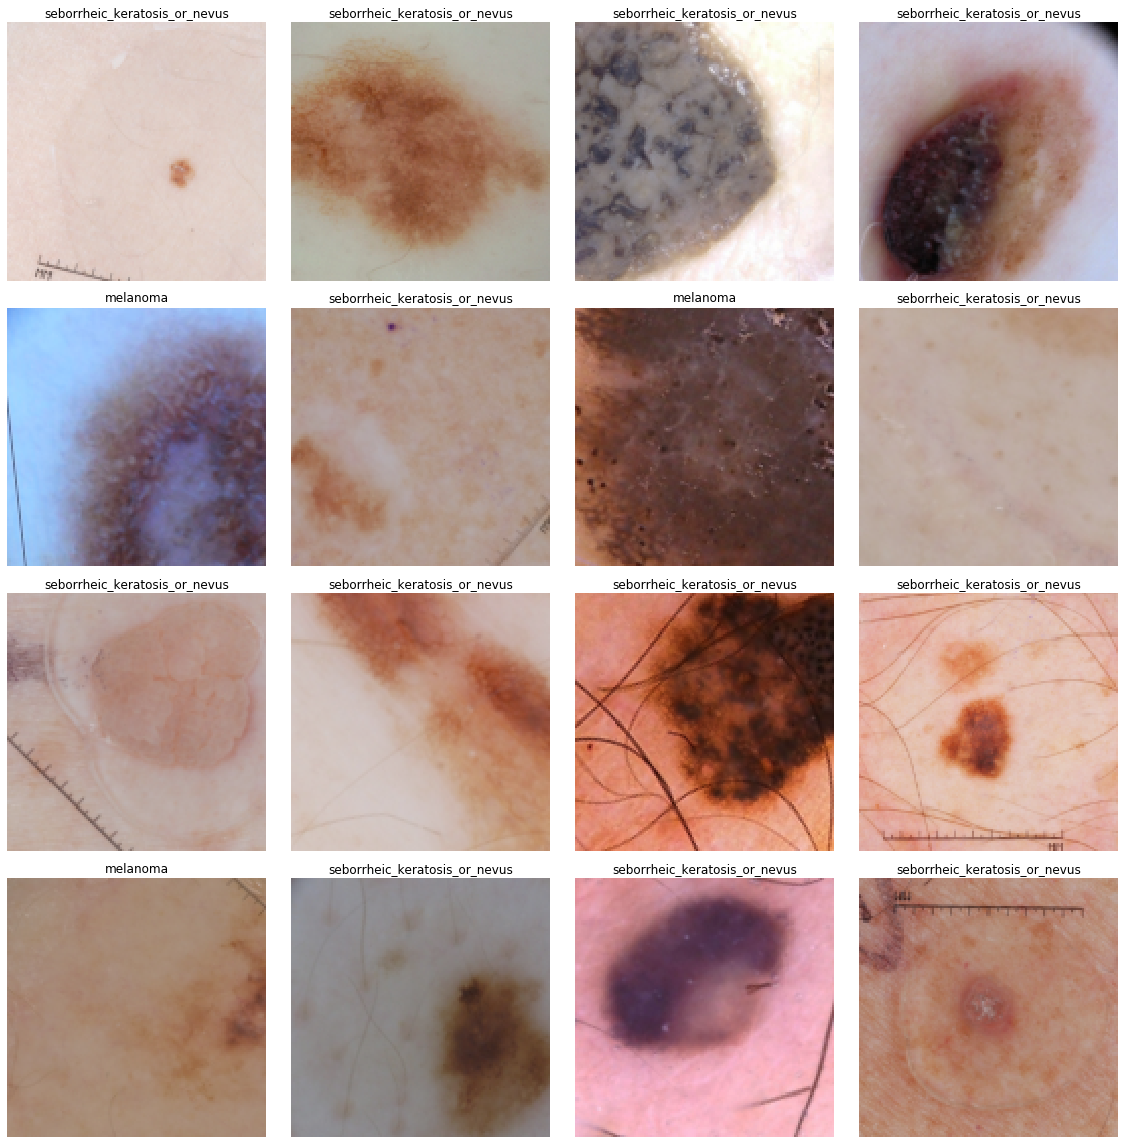

In [4]:
data.show_batch()

In [5]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# ARL-CNN50

In [6]:
from torchvision.models.resnet import Bottleneck
import types

In [29]:
alpha_initial_value = 0.0001
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        #identity N x C x H x W
        #alpha C
        #out N x C x H x W
        #out * identity * alpha = N x C x H x W
        
            
        out = out + (identity 
                     * self.softmaxLayer(out.view(*out.size()[:2], -1)).view_as(out) 
                     * self.alpha) + (identity)

        out = self.relu(out)
        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [35]:
ResNet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(ResNet50_with_attn, change_basic_blocks)

In [36]:
bottlenecks = [bn for bn in ResNet50_with_attn.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [32]:
for b in bottlenecks:
    assert b.alpha.requires_grad

## Create the learners

In [39]:
learn_baseline = cnn_learner(data, models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks) ], pretrained=True)

In [41]:
learn_baseline.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

In [37]:
learn_attn = cnn_learner(data, lambda x: ResNet50_with_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=bottlenecks) ], pretrained=True)

In [46]:
learn_attn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

In [49]:
ps = list(learn_attn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 16

ps = list(learn_baseline.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

assert len(ls) == 0

## Training

In [52]:
def train_model_and_return_metrics(data,model,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, model, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    
    #Unfreeze
    learner.unfreeze()
    random_seed(seed,True)
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))


    return accuracies

# Comparison Various seeds

In [53]:
results_file_name = 'resnet_50_arl_seed'
columns = ['Baseline','ARL']

In [54]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.046461,0.817731,0.286667,0.713333,0.658611,00:08
1,0.619178,0.643096,0.240000,0.760000,0.626111,00:08
2,0.510035,0.483138,0.200000,0.800000,0.750556,00:08
3,0.456716,0.429583,0.173333,0.826667,0.788333,00:08


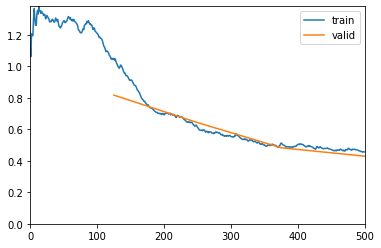

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.213778,0.473969,0.186667,0.813333,0.763056,00:13
1,0.146717,0.513247,0.186667,0.813333,0.790833,00:13


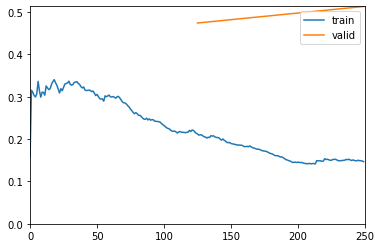

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.038881,0.700760,0.246667,0.753333,0.686944,00:07
1,0.653246,0.522411,0.193333,0.806667,0.663889,00:06
2,0.513633,0.547628,0.173333,0.826667,0.675833,00:07
3,0.455478,0.470628,0.160000,0.840000,0.755278,00:06


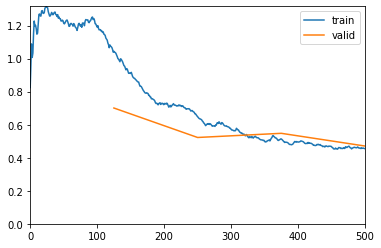

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.201850,0.549096,0.193333,0.806667,0.710000,00:12
1,0.152499,0.592148,0.180000,0.820000,0.697500,00:12


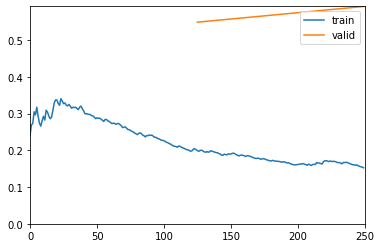

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.113508,0.673243,0.240000,0.760000,0.651944,00:07
1,0.627405,0.543734,0.193333,0.806667,0.645278,00:07
2,0.508016,0.454657,0.193333,0.806667,0.801667,00:07
3,0.460857,0.466029,0.186667,0.813333,0.765556,00:06


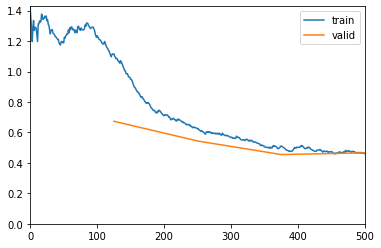

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.208976,0.471550,0.160000,0.840000,0.785556,00:12
1,0.164069,0.470761,0.166667,0.833333,0.793056,00:12


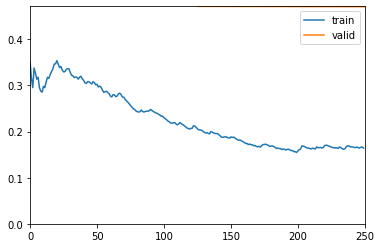

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.011597,0.647904,0.220000,0.780000,0.697222,00:06
1,0.613003,0.568125,0.206667,0.793333,0.687500,00:06
2,0.506002,0.458350,0.200000,0.800000,0.782500,00:07
3,0.458512,0.453489,0.200000,0.800000,0.774722,00:06


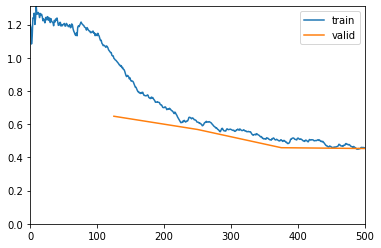

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.219613,0.473615,0.200000,0.800000,0.766667,00:12
1,0.155805,0.522776,0.193333,0.806667,0.765556,00:12


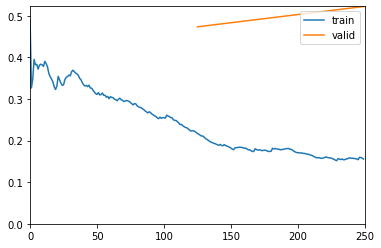

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.112815,0.726195,0.320000,0.680000,0.531111,00:07
1,0.622068,0.531708,0.173333,0.826667,0.658611,00:07
2,0.509695,0.512918,0.206667,0.793333,0.671667,00:07
3,0.437804,0.490941,0.186667,0.813333,0.709444,00:06


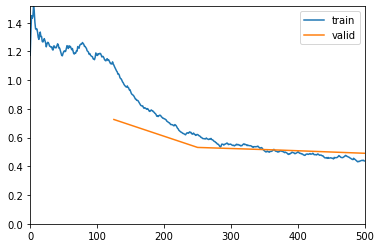

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.214603,0.607653,0.200000,0.800000,0.672778,00:12
1,0.152556,0.567841,0.206667,0.793333,0.710278,00:12


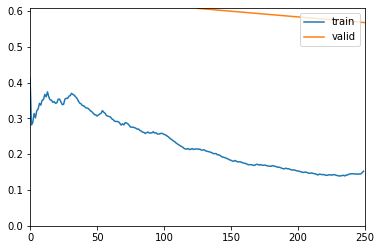

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.069588,0.779967,0.246667,0.753333,0.545000,00:07
1,0.590186,0.502526,0.166667,0.833333,0.692778,00:07
2,0.511046,0.522494,0.186667,0.813333,0.687500,00:07
3,0.440944,0.471268,0.186667,0.813333,0.738611,00:06


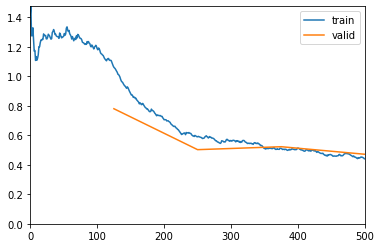

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.230016,0.538235,0.193333,0.806667,0.690278,00:16
1,0.147255,0.584164,0.186667,0.813333,0.696667,00:15


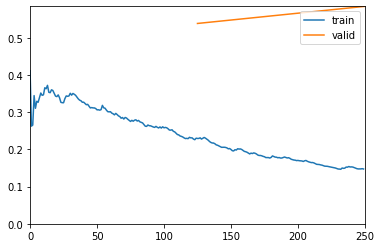

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.953293,0.797081,0.233333,0.766667,0.608889,00:06
1,0.610131,0.581919,0.180000,0.820000,0.632778,00:07
2,0.485094,0.525368,0.200000,0.800000,0.700833,00:07
3,0.468102,0.504748,0.186667,0.813333,0.715278,00:06


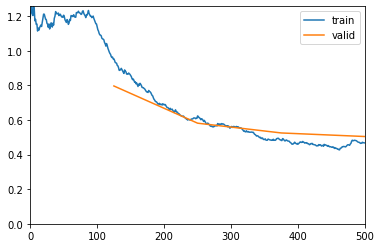

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.218107,0.568001,0.186667,0.813333,0.715000,00:12
1,0.155310,0.499833,0.173333,0.826667,0.743333,00:12


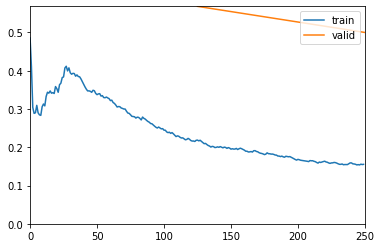

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.021934,0.711576,0.246667,0.753333,0.614167,00:07
1,0.638908,0.619063,0.193333,0.806667,0.641944,00:07
2,0.494445,0.505527,0.193333,0.806667,0.707500,00:07
3,0.470962,0.508639,0.193333,0.806667,0.708056,00:06


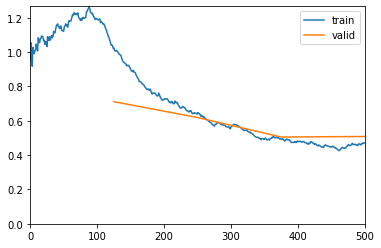

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.214056,0.496879,0.186667,0.813333,0.758056,00:12
1,0.164039,0.493897,0.193333,0.806667,0.783889,00:12


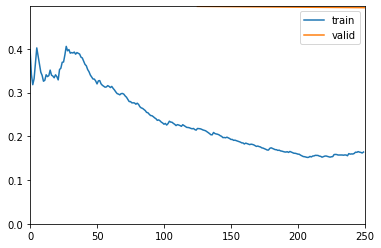

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.016941,0.819083,0.300000,0.700000,0.598333,00:07
1,0.628866,0.626866,0.180000,0.820000,0.659722,00:07
2,0.503247,0.579915,0.206667,0.793333,0.683056,00:07
3,0.453793,0.505400,0.200000,0.800000,0.754722,00:06


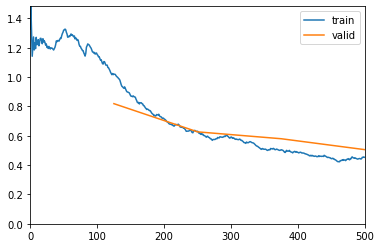

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.209079,0.549898,0.193333,0.806667,0.738889,00:12
1,0.157398,0.616113,0.206667,0.793333,0.720278,00:12


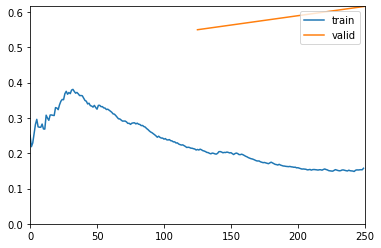

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.067037,0.726576,0.273333,0.726667,0.614722,00:06
1,0.627151,0.500629,0.193333,0.806667,0.715000,00:06
2,0.512027,0.459357,0.173333,0.826667,0.768056,00:07
3,0.470857,0.436059,0.180000,0.820000,0.797222,00:06


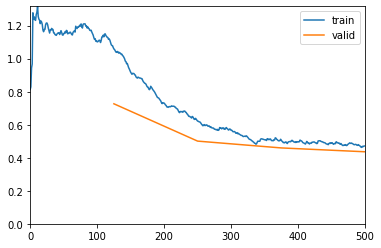

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.208624,0.480571,0.166667,0.833333,0.787222,00:12
1,0.162598,0.450221,0.180000,0.820000,0.804445,00:12


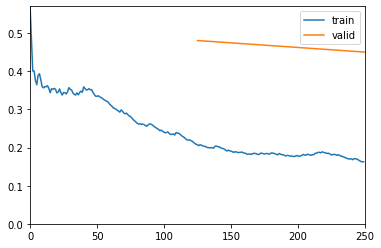

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.088730,0.720583,0.226667,0.773333,0.642778,00:07
1,0.605398,0.630827,0.180000,0.820000,0.588056,00:06
2,0.526397,0.538426,0.200000,0.800000,0.675556,00:07
3,0.460887,0.543402,0.193333,0.806667,0.697222,00:06


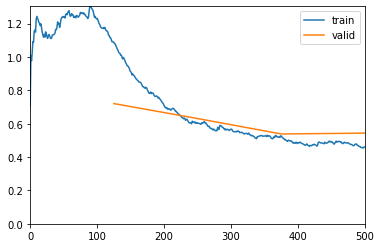

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.215279,0.582487,0.200000,0.800000,0.744722,00:12
1,0.152589,0.543496,0.193333,0.806667,0.756111,00:12


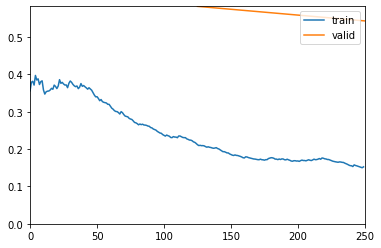

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.089050,0.648417,0.200000,0.800000,0.691111,00:08
1,0.618425,0.479210,0.166667,0.833333,0.781389,00:08
2,0.531001,0.500291,0.186667,0.813333,0.759167,00:08
3,0.462252,0.518526,0.193333,0.806667,0.707500,00:08


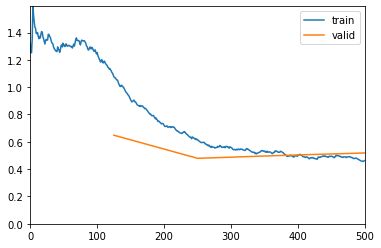

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.216601,0.701059,0.193333,0.806667,0.690833,00:13
1,0.162207,0.636461,0.186667,0.813333,0.718611,00:13


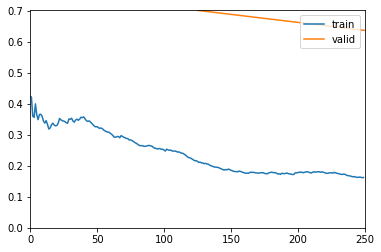

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.030995,0.703670,0.253333,0.746667,0.691111,00:06
1,0.658078,0.372811,0.146667,0.853333,0.821667,00:06
2,0.507090,0.438386,0.186667,0.813333,0.756111,00:07
3,0.448311,0.429767,0.173333,0.826667,0.785000,00:06


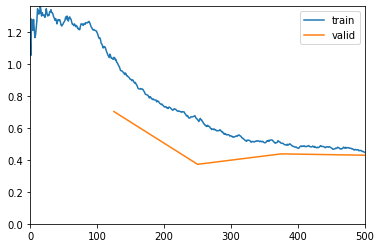

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.210514,0.524109,0.180000,0.820000,0.733056,00:13
1,0.146461,0.514091,0.173333,0.826667,0.769444,00:13


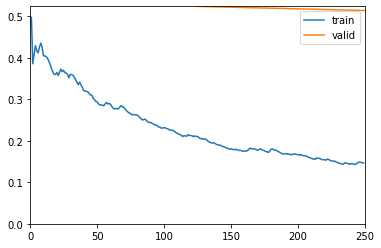

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.077082,0.616504,0.240000,0.760000,0.698889,00:07
1,0.615145,0.538332,0.226667,0.773333,0.680278,00:06
2,0.515168,0.525012,0.220000,0.780000,0.693333,00:07
3,0.460541,0.466485,0.193333,0.806667,0.745833,00:06


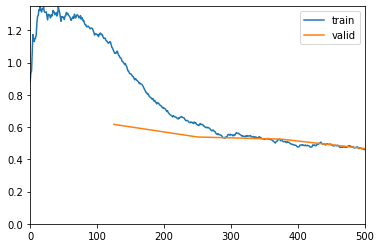

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.197136,0.552611,0.193333,0.806667,0.734445,00:13
1,0.164847,0.563456,0.180000,0.820000,0.741944,00:13


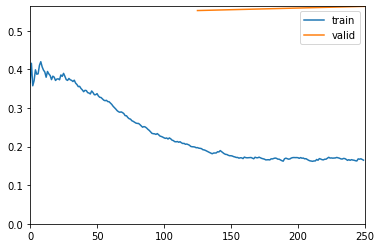

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.083442,0.713590,0.273333,0.726667,0.689167,00:07
1,0.623892,0.508238,0.206667,0.793333,0.720833,00:06
2,0.509162,0.526495,0.206667,0.793333,0.676111,00:07
3,0.454474,0.463377,0.193333,0.806667,0.759167,00:07


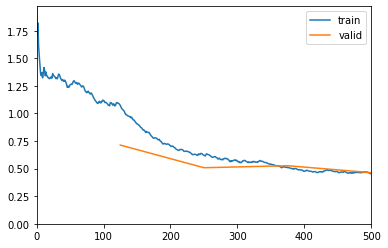

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.215322,0.576196,0.193333,0.806667,0.749444,00:13
1,0.174069,0.555350,0.206667,0.793333,0.773611,00:12


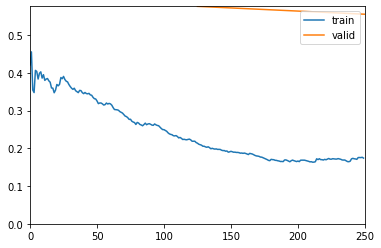

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.039035,0.976011,0.286667,0.713333,0.617222,00:06
1,0.618936,0.546076,0.186667,0.813333,0.684167,00:06
2,0.492618,0.482500,0.213333,0.786667,0.712778,00:06
3,0.438932,0.443109,0.180000,0.820000,0.750556,00:06


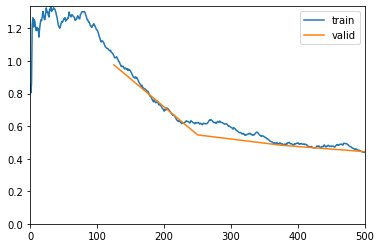

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.207531,0.479742,0.186667,0.813333,0.763333,00:12
1,0.151142,0.516813,0.173333,0.826667,0.759722,00:12


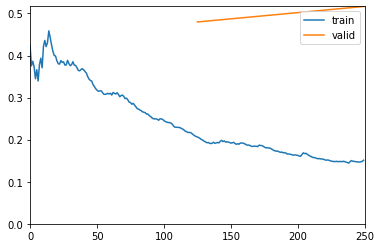

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.078604,0.754138,0.326667,0.673333,0.638611,00:07
1,0.637825,0.486668,0.186667,0.813333,0.723333,00:07
2,0.507620,0.548717,0.180000,0.820000,0.645833,00:06
3,0.452149,0.476882,0.180000,0.820000,0.729167,00:07


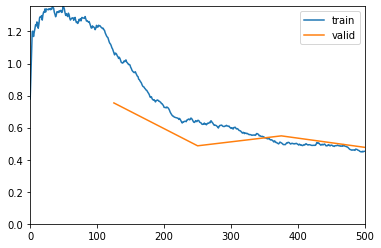

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.213904,0.497314,0.173333,0.826667,0.756944,00:11
1,0.153546,0.528092,0.193333,0.806667,0.768056,00:15


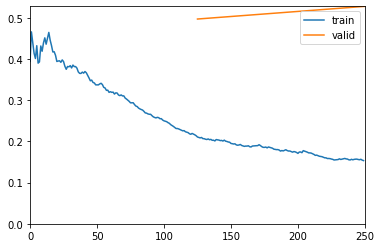

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.029054,0.850043,0.293333,0.706667,0.560278,00:07
1,0.617285,0.572613,0.220000,0.780000,0.672500,00:07
2,0.495432,0.478833,0.193333,0.806667,0.735833,00:06
3,0.450525,0.479569,0.200000,0.800000,0.736667,00:07


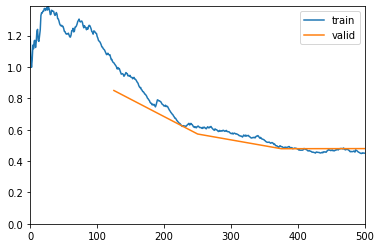

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.212160,0.559792,0.186667,0.813333,0.726944,00:12
1,0.160224,0.645282,0.193333,0.806667,0.724444,00:12


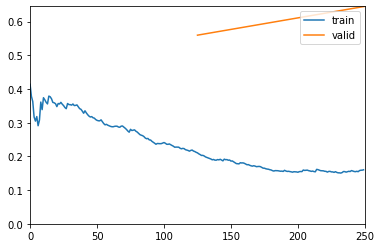

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.066156,0.850201,0.286667,0.713333,0.630833,00:06
1,0.641516,0.496837,0.200000,0.800000,0.729444,00:07
2,0.542107,0.468526,0.166667,0.833333,0.700000,00:06
3,0.461462,0.432517,0.173333,0.826667,0.766944,00:07


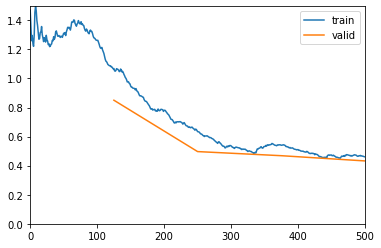

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.208573,0.491991,0.193333,0.806667,0.788333,00:12
1,0.152219,0.460765,0.193333,0.806667,0.775833,00:12


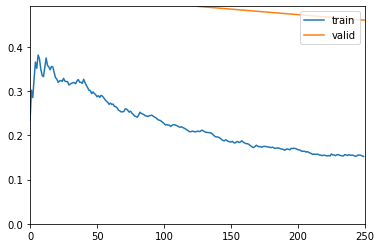

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.197923,0.764284,0.220000,0.780000,0.690555,00:06
1,0.628306,0.574510,0.246667,0.753333,0.651111,00:07
2,0.527202,0.486340,0.206667,0.793333,0.755000,00:06
3,0.464584,0.463673,0.213333,0.786667,0.743889,00:07


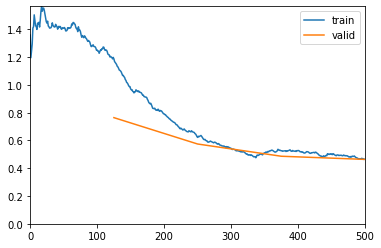

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.226563,0.539474,0.206667,0.793333,0.735000,00:12
1,0.164821,0.538073,0.193333,0.806667,0.728611,00:12


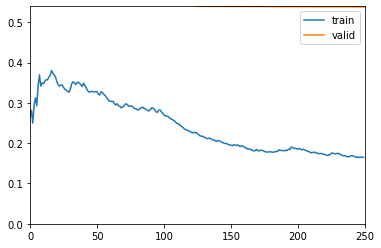

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.112020,1.212219,0.233333,0.766667,0.560833,00:07
1,0.624553,0.552830,0.206667,0.793333,0.728056,00:07
2,0.533884,0.513731,0.200000,0.800000,0.713333,00:06
3,0.458967,0.450373,0.200000,0.800000,0.801389,00:07


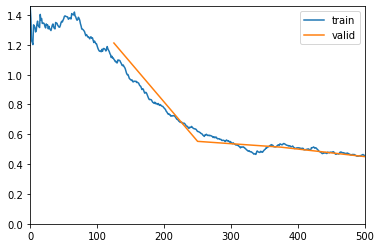

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.207143,0.564986,0.193333,0.806667,0.763056,00:12
1,0.146758,0.645507,0.193333,0.806667,0.673889,00:12


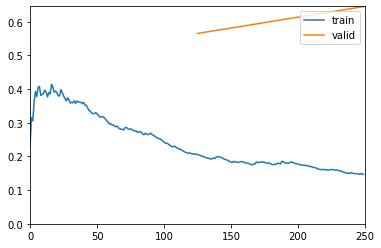

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.062990,0.692079,0.280000,0.720000,0.613056,00:06
1,0.668663,0.470359,0.193333,0.806667,0.734167,00:07
2,0.497970,0.463002,0.180000,0.820000,0.739722,00:06
3,0.443014,0.455459,0.166667,0.833333,0.758333,00:07


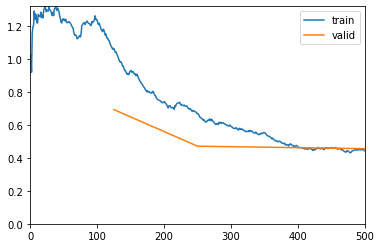

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.240678,0.551034,0.193333,0.806667,0.739444,00:12
1,0.166938,0.515249,0.186667,0.813333,0.752500,00:12


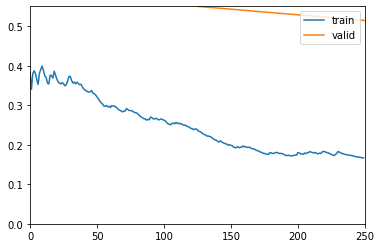

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.036268,0.641343,0.206667,0.793333,0.656667,00:06
1,0.660018,0.513485,0.213333,0.786667,0.701667,00:08
2,0.510534,0.475681,0.200000,0.800000,0.736944,00:08
3,0.466779,0.460998,0.186667,0.813333,0.761389,00:08


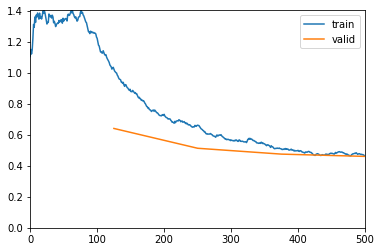

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.211710,0.454060,0.180000,0.820000,0.777222,00:14
1,0.159974,0.463185,0.186667,0.813333,0.779722,00:12


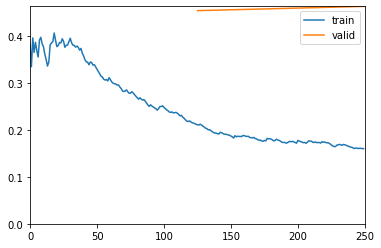

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


In [ ]:
seeds = range(1,11)
epochs = 2

for seed in seeds:
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_acc = train_model_and_return_metrics(data,models.resnet50, seed,epochs)
    
    #ARL
    data = reload_dataset(dm,seed=seed)
    
    ResNet50_with_attn = models.resnet50(pretrained=True)
    apply_leaf(ResNet50_with_attn, change_basic_blocks)
    
    arl_acc = train_model_and_return_metrics(data,lambda x: ResNet50_with_attn, seed,epochs)


    
    write_results(seed, baseline_acc, arl_acc)
    

### Without Attention

In [464]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [465]:

random_seed(1,True)

learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ], pretrained=True)
learn.unfreeze()
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
___________________________________________________

In [466]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.74E-04


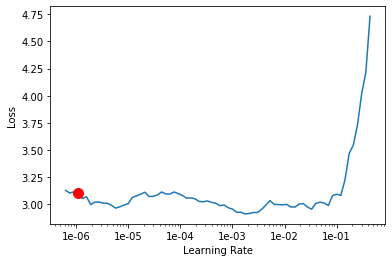

In [467]:
learn.recorder.plot(suggestion=True)

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_Resnet50


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.854325,1.938749,0.697509,0.302491,0.476369,00:15
1,2.364213,1.696003,0.585409,0.414591,0.511130,00:15
2,2.050347,1.529050,0.546263,0.453737,0.448927,00:15
3,1.837201,1.515553,0.530249,0.469751,0.488467,00:15
4,1.790631,1.406590,0.462633,0.537367,0.544961,00:15
5,1.832997,1.614178,0.494662,0.505338,0.497422,00:15
6,1.605215,1.335961,0.459075,0.540925,0.443721,00:15
7,1.667350,1.414169,0.496441,0.503559,0.394069,00:15
8,1.729030,1.593126,0.494662,0.505338,0.534975,00:15
9,1.627197,1.362526,0.483986,0.516014,0.546797,00:15


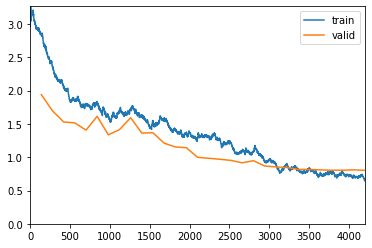

Better model found at epoch 0 with accuracy value: 0.30249109864234924.
Better model found at epoch 1 with accuracy value: 0.4145907461643219.
Better model found at epoch 2 with accuracy value: 0.45373666286468506.
Better model found at epoch 3 with accuracy value: 0.46975088119506836.
Better model found at epoch 4 with accuracy value: 0.5373665690422058.
Better model found at epoch 6 with accuracy value: 0.5409252643585205.
Better model found at epoch 12 with accuracy value: 0.5658363103866577.
Better model found at epoch 13 with accuracy value: 0.5925266742706299.
Better model found at epoch 14 with accuracy value: 0.6192170977592468.
Better model found at epoch 17 with accuracy value: 0.6316726207733154.
Better model found at epoch 18 with accuracy value: 0.6334519386291504.
Better model found at epoch 19 with accuracy value: 0.6583629846572876.
Better model found at epoch 23 with accuracy value: 0.6957295536994934.


In [468]:
train_learner(learn,'Resnet50',epochs=30,lr=1.74e-04)

## With Attention Residual Learning

In [455]:
from torchvision.models.resnet import Bottleneck
import types

In [456]:
r50_attn = models.resnet50(pretrained=True)

In [457]:
alpha_initial_value = 0.001
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        #identity N x C x H x W
        #alpha C
        #out N x C x H x W
        #out * identity * alpha = N x C x H x W
        
            
        out = out + (identity 
                     * self.softmaxLayer(out.view(*out.size()[:2], -1)).view_as(out) 
                     * self.alpha) + (identity)

        out = self.relu(out)
        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [458]:
apply_leaf(r50_attn, change_basic_blocks)

In [459]:
data = reload_dataset(images_folder)

In [460]:
bottlenecks = [bn for bn in r50_attn.modules() if isinstance(bn,Bottleneck)]

In [461]:
class Alphas(ActivationStats):

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [462]:
random_seed(1,True)

learn_attn = cnn_learner(data, lambda x: r50_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
#                             partial(Alphas, modules=bottlenecks),

                                ], pretrained=True)
learn_attn.unfreeze()
# learn_attn.summary()

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_Resnet50-Attn


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.855499,1.939861,0.706406,0.293594,0.473854,00:14
1,2.363097,1.667820,0.596085,0.403915,0.504263,00:14
2,2.133955,1.493301,0.535587,0.464413,0.448575,00:14
3,1.897977,1.482962,0.510676,0.489324,0.437432,00:14
4,1.857372,1.685644,0.507117,0.492883,0.419725,00:14
5,1.799036,1.805125,0.523132,0.476868,0.354378,00:14
6,1.719373,1.321804,0.450178,0.549822,0.458385,00:14
7,1.705546,2.197560,0.581851,0.418149,0.470307,00:14
8,1.746518,1.246073,0.444840,0.555160,0.522046,00:14
9,1.587314,1.440395,0.489324,0.510676,0.678195,00:14


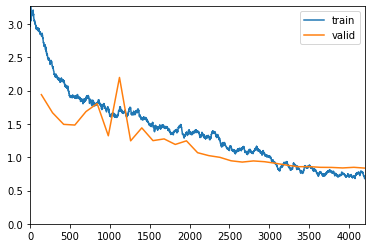

Better model found at epoch 0 with accuracy value: 0.2935943007469177.
Better model found at epoch 1 with accuracy value: 0.40391460061073303.
Better model found at epoch 2 with accuracy value: 0.4644128084182739.
Better model found at epoch 3 with accuracy value: 0.48932385444641113.
Better model found at epoch 4 with accuracy value: 0.49288254976272583.
Better model found at epoch 6 with accuracy value: 0.5498220920562744.
Better model found at epoch 8 with accuracy value: 0.5551601648330688.
Better model found at epoch 12 with accuracy value: 0.5693950057029724.
Better model found at epoch 14 with accuracy value: 0.599644124507904.
Better model found at epoch 15 with accuracy value: 0.6032028198242188.
Better model found at epoch 16 with accuracy value: 0.6049821972846985.
Better model found at epoch 17 with accuracy value: 0.6209964156150818.
Better model found at epoch 18 with accuracy value: 0.6334519386291504.
Better model found at epoch 20 with accuracy value: 0.649466216564178

In [463]:
train_learner(learn_attn,'Resnet50-Attn',epochs=30,lr=1.74e-04)

In [472]:
learn_attn.recorder.metrics

[[tensor(0.5907), tensor(0.4093), tensor(0.4887)],
 [tensor(0.5160), tensor(0.4840), tensor(0.4541)]]

In [408]:
ps = list(learn_attn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

len(ls)

16

In [409]:
ls

[('0.4.0.alpha',
  Parameter containing:
  tensor(-0.0007, device='cuda:0', requires_grad=True)),
 ('0.4.1.alpha',
  Parameter containing:
  tensor(7.3457e-05, device='cuda:0', requires_grad=True)),
 ('0.4.2.alpha',
  Parameter containing:
  tensor(-4.1451e-05, device='cuda:0', requires_grad=True)),
 ('0.5.0.alpha',
  Parameter containing:
  tensor(0.0025, device='cuda:0', requires_grad=True)),
 ('0.5.1.alpha',
  Parameter containing:
  tensor(0.0029, device='cuda:0', requires_grad=True)),
 ('0.5.2.alpha',
  Parameter containing:
  tensor(0.0033, device='cuda:0', requires_grad=True)),
 ('0.5.3.alpha',
  Parameter containing:
  tensor(0.0030, device='cuda:0', requires_grad=True)),
 ('0.6.0.alpha',
  Parameter containing:
  tensor(0.0040, device='cuda:0', requires_grad=True)),
 ('0.6.1.alpha',
  Parameter containing:
  tensor(0.0029, device='cuda:0', requires_grad=True)),
 ('0.6.2.alpha',
  Parameter containing:
  tensor(0.0045, device='cuda:0', requires_grad=True)),
 ('0.6.3.alpha',
  P

# Test

In [302]:
import torchvision

In [330]:
res = nn.Softmax(2)(sample_item.view(*sample_item.size()[:2], -1)).view_as(sample_item)

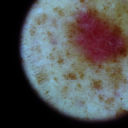

In [332]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(res.cpu()[0] * 5255)
img

In [336]:
res.mean(dim=[0,2,3])

tensor([6.1035e-05, 6.1035e-05, 6.1035e-05], device='cuda:0')

In [255]:
res.mean(dim=[0,2,3])

tensor([0.5925, 0.1743, 0.2332], device='cuda:0')

In [198]:
batch = data.one_batch()[0]

In [205]:
resm = nn.Softmax2d()(batch) - torch.tensor(1)

In [206]:
resm[0].mean()

tensor(-0.6667)

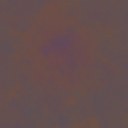

In [200]:
to_pil(batch[0])
to_pil(resm[0])

# Compare

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_ResNet50


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.865351,1.971769,0.722420,0.277580,0.477828,00:13
1,2.432095,1.725007,0.613879,0.386121,0.483311,00:13
2,2.224288,1.556337,0.565836,0.434164,0.464924,00:13
3,1.919692,1.425578,0.505338,0.494662,0.439092,00:13
4,1.885286,1.396772,0.471530,0.528470,0.497221,00:13
5,1.786017,1.514903,0.467972,0.532028,0.486329,00:13
6,1.607436,1.462184,0.492883,0.507117,0.556682,00:13
7,1.711420,1.465801,0.469751,0.530249,0.547224,00:13
8,1.718087,1.220718,0.430605,0.569395,0.463767,00:13
9,1.600385,1.365740,0.450178,0.549822,0.642478,00:13


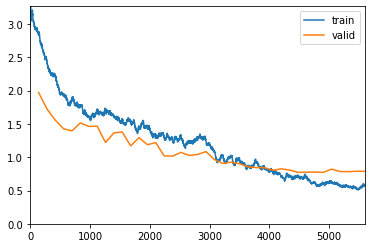

Better model found at epoch 0 with accuracy value: 0.2775800824165344.
Better model found at epoch 1 with accuracy value: 0.38612100481987.
Better model found at epoch 2 with accuracy value: 0.4341636896133423.
Better model found at epoch 3 with accuracy value: 0.49466192722320557.
Better model found at epoch 4 with accuracy value: 0.5284697413444519.
Better model found at epoch 5 with accuracy value: 0.5320284962654114.
Better model found at epoch 8 with accuracy value: 0.5693950057029724.
Better model found at epoch 13 with accuracy value: 0.5765124559402466.
Better model found at epoch 14 with accuracy value: 0.6298932433128357.
Better model found at epoch 22 with accuracy value: 0.6405693888664246.
Better model found at epoch 23 with accuracy value: 0.6441280841827393.
Better model found at epoch 24 with accuracy value: 0.6512455344200134.
Better model found at epoch 25 with accuracy value: 0.6583629846572876.
Better model found at epoch 26 with accuracy value: 0.6761565804481506.


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.873811,1.968226,0.720641,0.279359,0.482758,00:14
1,2.425081,1.744734,0.613879,0.386121,0.491058,00:14
2,2.187527,1.584594,0.558719,0.441281,0.440224,00:14
3,1.909711,1.430612,0.503559,0.496441,0.457127,00:14
4,1.854997,1.350643,0.464413,0.535587,0.473401,00:14
5,1.740478,1.400670,0.466192,0.533808,0.438564,00:14
6,1.635669,1.415762,0.459075,0.540925,0.490480,00:14
7,1.681954,1.531393,0.508897,0.491103,0.473351,00:14
8,1.715797,1.278202,0.462633,0.537367,0.523430,00:14
9,1.581241,1.172205,0.448399,0.551601,0.565108,00:14


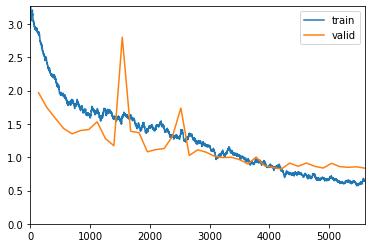

Better model found at epoch 0 with accuracy value: 0.2793594300746918.
Better model found at epoch 1 with accuracy value: 0.38612100481987.
Better model found at epoch 2 with accuracy value: 0.44128113985061646.
Better model found at epoch 3 with accuracy value: 0.4964412748813629.
Better model found at epoch 4 with accuracy value: 0.5355871915817261.
Better model found at epoch 6 with accuracy value: 0.5409252643585205.
Better model found at epoch 9 with accuracy value: 0.5516014099121094.
Better model found at epoch 13 with accuracy value: 0.564056932926178.
Better model found at epoch 14 with accuracy value: 0.5658363103866577.
Better model found at epoch 18 with accuracy value: 0.6032028198242188.
Better model found at epoch 19 with accuracy value: 0.6049821972846985.
Better model found at epoch 21 with accuracy value: 0.6174377202987671.
Better model found at epoch 22 with accuracy value: 0.628113865852356.
Better model found at epoch 24 with accuracy value: 0.6405693888664246.
Be

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.870363,1.968396,0.695730,0.304270,0.476822,00:14
1,2.402083,1.657829,0.597865,0.402135,0.471892,00:13
2,2.084375,1.556430,0.553381,0.446619,0.457781,00:13
3,1.942244,1.395437,0.476868,0.523132,0.447091,00:13
4,1.824264,1.360905,0.469751,0.530249,0.446186,00:13
5,1.758350,1.332667,0.483986,0.516014,0.494479,00:13
6,1.663910,1.283218,0.457295,0.542705,0.410242,00:13
7,1.692211,1.365053,0.476868,0.523132,0.453907,00:13
8,1.661633,1.254350,0.473310,0.526690,0.410016,00:14
9,1.624097,1.324685,0.467972,0.532028,0.429384,00:13


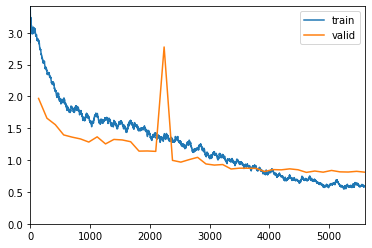

Better model found at epoch 0 with accuracy value: 0.304270476102829.
Better model found at epoch 1 with accuracy value: 0.4021352231502533.
Better model found at epoch 2 with accuracy value: 0.4466192126274109.
Better model found at epoch 3 with accuracy value: 0.5231316685676575.
Better model found at epoch 4 with accuracy value: 0.5302491188049316.
Better model found at epoch 6 with accuracy value: 0.5427046418190002.
Better model found at epoch 12 with accuracy value: 0.564056932926178.
Better model found at epoch 13 with accuracy value: 0.599644124507904.
Better model found at epoch 16 with accuracy value: 0.6067615747451782.
Better model found at epoch 17 with accuracy value: 0.6352313160896301.
Better model found at epoch 21 with accuracy value: 0.6387900114059448.
Better model found at epoch 22 with accuracy value: 0.6405693888664246.
Better model found at epoch 23 with accuracy value: 0.6548042893409729.
Better model found at epoch 26 with accuracy value: 0.6708185076713562.
B

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.871858,1.965140,0.695730,0.304270,0.478306,00:14
1,2.404243,1.667704,0.608541,0.391459,0.472294,00:14
2,2.071517,1.592350,0.572954,0.427046,0.463164,00:14
3,1.921538,1.441051,0.526690,0.473310,0.470760,00:14
4,1.836587,1.417353,0.482206,0.517794,0.506125,00:14
5,1.808388,1.283023,0.473310,0.526690,0.429811,00:14
6,1.708055,1.369955,0.489324,0.510676,0.419901,00:14
7,1.712098,1.269158,0.448399,0.551601,0.480066,00:14
8,1.662891,1.334772,0.473310,0.526690,0.522323,00:14
9,1.546813,1.339119,0.457295,0.542705,0.537817,00:14


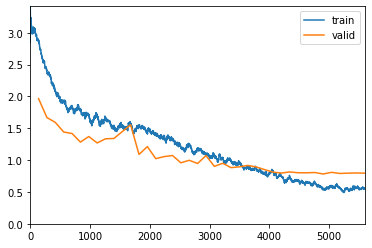

Better model found at epoch 0 with accuracy value: 0.304270476102829.
Better model found at epoch 1 with accuracy value: 0.39145907759666443.
Better model found at epoch 2 with accuracy value: 0.4270462691783905.
Better model found at epoch 3 with accuracy value: 0.47330960631370544.
Better model found at epoch 4 with accuracy value: 0.517793595790863.
Better model found at epoch 5 with accuracy value: 0.5266903638839722.
Better model found at epoch 7 with accuracy value: 0.5516014099121094.
Better model found at epoch 12 with accuracy value: 0.5782918334007263.
Better model found at epoch 13 with accuracy value: 0.5871886014938354.
Better model found at epoch 14 with accuracy value: 0.599644124507904.
Better model found at epoch 17 with accuracy value: 0.6032028198242188.
Better model found at epoch 18 with accuracy value: 0.6245551705360413.
Better model found at epoch 19 with accuracy value: 0.6512455344200134.
Better model found at epoch 23 with accuracy value: 0.6583629846572876.


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.749642,1.994051,0.725979,0.274021,0.477627,00:13
1,2.430991,1.680061,0.613879,0.386121,0.474684,00:13
2,2.124430,1.505941,0.535587,0.464413,0.483714,00:14
3,1.908403,1.434590,0.530249,0.469751,0.476771,00:14
4,1.893383,1.537703,0.500000,0.500000,0.476319,00:13
5,1.808209,1.354739,0.480427,0.519573,0.562417,00:13
6,1.613412,1.351748,0.473310,0.526690,0.576075,00:14
7,1.783398,1.207550,0.443060,0.556939,0.484695,00:14
8,1.619640,1.159588,0.451957,0.548043,0.513495,00:14
9,1.649305,1.464376,0.487544,0.512456,0.438715,00:14


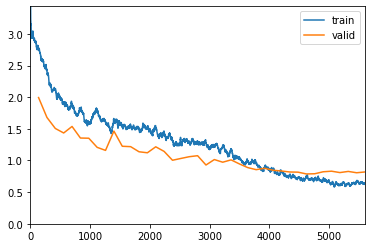

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.38612100481987.
Better model found at epoch 2 with accuracy value: 0.4644128084182739.
Better model found at epoch 3 with accuracy value: 0.46975088119506836.
Better model found at epoch 4 with accuracy value: 0.5.
Better model found at epoch 5 with accuracy value: 0.5195729732513428.
Better model found at epoch 6 with accuracy value: 0.5266903638839722.
Better model found at epoch 7 with accuracy value: 0.5569394826889038.
Better model found at epoch 10 with accuracy value: 0.5782918334007263.
Better model found at epoch 16 with accuracy value: 0.5943060517311096.
Better model found at epoch 20 with accuracy value: 0.6245551705360413.
Better model found at epoch 24 with accuracy value: 0.645907461643219.
Better model found at epoch 25 with accuracy value: 0.6476868391036987.
Better model found at epoch 26 with accuracy value: 0.6548042893409729.
Better model fou

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.740675,1.995738,0.725979,0.274021,0.481525,00:14
1,2.424493,1.676376,0.604982,0.395018,0.480167,00:14
2,2.124177,1.498683,0.535587,0.464413,0.464094,00:14
3,1.948992,1.480871,0.505338,0.494662,0.499157,00:14
4,1.851017,1.474131,0.469751,0.530249,0.471439,00:14
5,1.792315,1.339627,0.466192,0.533808,0.503609,00:14
6,1.682556,1.529947,0.467972,0.532028,0.507533,00:14
7,1.761645,1.249100,0.434164,0.565836,0.489650,00:14
8,1.660601,1.372911,0.482206,0.517794,0.486103,00:14
9,1.624706,1.446857,0.480427,0.519573,0.408934,00:14


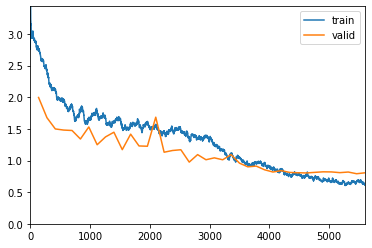

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.3950178027153015.
Better model found at epoch 2 with accuracy value: 0.4644128084182739.
Better model found at epoch 3 with accuracy value: 0.49466192722320557.
Better model found at epoch 4 with accuracy value: 0.5302491188049316.
Better model found at epoch 5 with accuracy value: 0.5338078141212463.
Better model found at epoch 7 with accuracy value: 0.5658363103866577.
Better model found at epoch 10 with accuracy value: 0.5782918334007263.
Better model found at epoch 18 with accuracy value: 0.6227757930755615.
Better model found at epoch 22 with accuracy value: 0.6334519386291504.
Better model found at epoch 25 with accuracy value: 0.6654804348945618.
Better model found at epoch 28 with accuracy value: 0.6743772029876709.
Better model found at epoch 31 with accuracy value: 0.6779359579086304.
Better model found at epoch 32 with accuracy value: 0.681494653224945

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.885439,1.971996,0.704626,0.295374,0.467188,00:13
1,2.309188,1.699765,0.620996,0.379004,0.447292,00:14
2,2.105439,1.573219,0.549822,0.450178,0.453480,00:14
3,1.943623,1.475375,0.519573,0.480427,0.463793,00:14
4,1.810658,1.409288,0.475089,0.524911,0.374827,00:14
5,1.754836,1.394580,0.483986,0.516014,0.516890,00:13
6,1.721444,1.359168,0.482206,0.517794,0.456750,00:14
7,1.587476,1.386269,0.482206,0.517794,0.513168,00:13
8,1.536278,1.159474,0.444840,0.555160,0.449229,00:14
9,1.600025,1.371205,0.459075,0.540925,0.496441,00:14


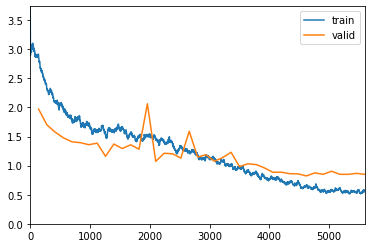

Better model found at epoch 0 with accuracy value: 0.29537367820739746.
Better model found at epoch 1 with accuracy value: 0.3790035545825958.
Better model found at epoch 2 with accuracy value: 0.450177937746048.
Better model found at epoch 3 with accuracy value: 0.4804270565509796.
Better model found at epoch 4 with accuracy value: 0.5249110460281372.
Better model found at epoch 8 with accuracy value: 0.5551601648330688.
Better model found at epoch 11 with accuracy value: 0.5604982376098633.
Better model found at epoch 12 with accuracy value: 0.5622775554656982.
Better model found at epoch 14 with accuracy value: 0.5925266742706299.
Better model found at epoch 19 with accuracy value: 0.6120996475219727.
Better model found at epoch 21 with accuracy value: 0.6156583428382874.
Better model found at epoch 22 with accuracy value: 0.6174377202987671.
Better model found at epoch 24 with accuracy value: 0.6192170977592468.
Better model found at epoch 25 with accuracy value: 0.6423487663269043

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.883968,1.975732,0.701068,0.298932,0.468068,00:14
1,2.304967,1.720343,0.613879,0.386121,0.467817,00:14
2,2.086041,1.640264,0.560498,0.439502,0.457504,00:14
3,1.890082,1.505455,0.521352,0.478648,0.502226,00:14
4,1.810996,1.510029,0.492883,0.507117,0.462208,00:14
5,1.748951,1.467482,0.462633,0.537367,0.539050,00:14
6,1.711638,1.433329,0.480427,0.519573,0.475816,00:14
7,1.644988,1.314540,0.482206,0.517794,0.566290,00:14
8,1.570593,1.133625,0.437722,0.562278,0.484015,00:14
9,1.654436,1.831686,0.482206,0.517794,0.491989,00:14


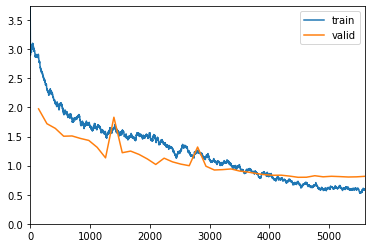

Better model found at epoch 0 with accuracy value: 0.29893237352371216.
Better model found at epoch 1 with accuracy value: 0.38612100481987.
Better model found at epoch 2 with accuracy value: 0.4395017921924591.
Better model found at epoch 3 with accuracy value: 0.4786476790904999.
Better model found at epoch 4 with accuracy value: 0.5071174502372742.
Better model found at epoch 5 with accuracy value: 0.5373665690422058.
Better model found at epoch 8 with accuracy value: 0.5622775554656982.
Better model found at epoch 14 with accuracy value: 0.6067615747451782.
Better model found at epoch 18 with accuracy value: 0.6120996475219727.
Better model found at epoch 21 with accuracy value: 0.6352313160896301.
Better model found at epoch 22 with accuracy value: 0.6405693888664246.
Better model found at epoch 23 with accuracy value: 0.6565836071968079.
Better model found at epoch 26 with accuracy value: 0.6725978851318359.
Better model found at epoch 30 with accuracy value: 0.6975088715553284.


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.793473,1.994924,0.711744,0.288256,0.472017,00:13
1,2.427522,1.720300,0.622776,0.377224,0.425837,00:14
2,2.144896,1.561316,0.560498,0.439502,0.436225,00:14
3,1.891376,1.456375,0.510676,0.489324,0.528385,00:13
4,1.784516,1.552228,0.496441,0.503559,0.406142,00:14
5,1.843171,1.399785,0.494662,0.505338,0.361622,00:14
6,1.795102,1.530570,0.498221,0.501779,0.524034,00:14
7,1.799865,1.389376,0.487544,0.512456,0.420530,00:14
8,1.676844,1.984895,0.508897,0.491103,0.396031,00:13
9,1.639118,1.420047,0.441281,0.558719,0.621903,00:14


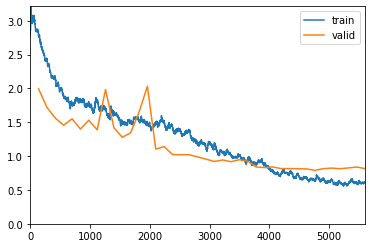

Better model found at epoch 0 with accuracy value: 0.2882562279701233.
Better model found at epoch 1 with accuracy value: 0.3772242069244385.
Better model found at epoch 2 with accuracy value: 0.4395017921924591.
Better model found at epoch 3 with accuracy value: 0.48932385444641113.
Better model found at epoch 4 with accuracy value: 0.5035586953163147.
Better model found at epoch 5 with accuracy value: 0.5053380727767944.
Better model found at epoch 7 with accuracy value: 0.5124555230140686.
Better model found at epoch 9 with accuracy value: 0.5587188601493835.
Better model found at epoch 10 with accuracy value: 0.581850528717041.
Better model found at epoch 16 with accuracy value: 0.608540952205658.
Better model found at epoch 20 with accuracy value: 0.6352313160896301.
Better model found at epoch 21 with accuracy value: 0.6370106935501099.
Better model found at epoch 23 with accuracy value: 0.6441280841827393.
Better model found at epoch 24 with accuracy value: 0.645907461643219.
Be

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.795387,1.994649,0.720641,0.279359,0.468949,00:14
1,2.435618,1.706686,0.613879,0.386121,0.440400,00:14
2,2.183689,1.544097,0.558719,0.441281,0.462183,00:14
3,1.942458,1.487074,0.521352,0.478648,0.466107,00:14
4,1.889750,1.452968,0.500000,0.500000,0.467540,00:14
5,1.809410,1.502040,0.487544,0.512456,0.389994,00:14
6,1.730448,1.313275,0.466192,0.533808,0.560631,00:14
7,1.688525,1.310981,0.453737,0.546263,0.514626,00:14
8,1.575539,1.298738,0.437722,0.562278,0.496667,00:14
9,1.602909,1.410318,0.487544,0.512456,0.453178,00:14


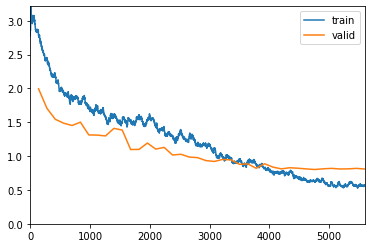

Better model found at epoch 0 with accuracy value: 0.2793594300746918.
Better model found at epoch 1 with accuracy value: 0.38612100481987.
Better model found at epoch 2 with accuracy value: 0.44128113985061646.
Better model found at epoch 3 with accuracy value: 0.4786476790904999.
Better model found at epoch 4 with accuracy value: 0.5.
Better model found at epoch 5 with accuracy value: 0.5124555230140686.
Better model found at epoch 6 with accuracy value: 0.5338078141212463.
Better model found at epoch 7 with accuracy value: 0.5462633371353149.
Better model found at epoch 8 with accuracy value: 0.5622775554656982.
Better model found at epoch 11 with accuracy value: 0.5729537606239319.
Better model found at epoch 12 with accuracy value: 0.5854092240333557.
Better model found at epoch 15 with accuracy value: 0.6014235019683838.
Better model found at epoch 18 with accuracy value: 0.6227757930755615.
Better model found at epoch 19 with accuracy value: 0.6387900114059448.
Better model foun

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.805902,2.029274,0.745552,0.254448,0.484015,00:14
1,2.427735,1.666600,0.604982,0.395018,0.424353,00:13
2,2.161474,1.574288,0.574733,0.425267,0.442337,00:14
3,1.971829,1.488630,0.482206,0.517794,0.480695,00:14
4,1.888124,1.386270,0.503559,0.496441,0.454838,00:14
5,1.864851,1.624549,0.491103,0.508897,0.513318,00:13
6,1.722156,1.426321,0.485765,0.514235,0.498931,00:13
7,1.725139,1.250266,0.467972,0.532028,0.588400,00:14
8,1.691644,1.298133,0.448399,0.551601,0.528284,00:13
9,1.583888,1.373379,0.467972,0.532028,0.499660,00:14


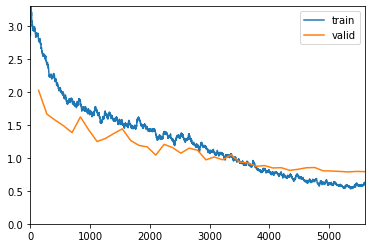

Better model found at epoch 0 with accuracy value: 0.25444838404655457.
Better model found at epoch 1 with accuracy value: 0.3950178027153015.
Better model found at epoch 2 with accuracy value: 0.42526689171791077.
Better model found at epoch 3 with accuracy value: 0.517793595790863.
Better model found at epoch 7 with accuracy value: 0.5320284962654114.
Better model found at epoch 8 with accuracy value: 0.5516014099121094.
Better model found at epoch 14 with accuracy value: 0.5782918334007263.
Better model found at epoch 15 with accuracy value: 0.5925266742706299.
Better model found at epoch 19 with accuracy value: 0.5943060517311096.
Better model found at epoch 20 with accuracy value: 0.6156583428382874.
Better model found at epoch 22 with accuracy value: 0.6209964156150818.
Better model found at epoch 24 with accuracy value: 0.6548042893409729.
Better model found at epoch 26 with accuracy value: 0.6583629846572876.
Better model found at epoch 28 with accuracy value: 0.660142362117767

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.796165,2.031296,0.743772,0.256228,0.489826,00:14
1,2.415615,1.666959,0.617438,0.382562,0.430364,00:14
2,2.144182,1.570584,0.564057,0.435943,0.455568,00:14
3,1.981838,1.524442,0.482206,0.517794,0.492366,00:14
4,1.824159,1.467935,0.467972,0.532028,0.428478,00:14
5,1.823644,1.485610,0.457295,0.542705,0.473049,00:14
6,1.771056,1.390997,0.455516,0.544484,0.415147,00:14
7,1.811964,1.287131,0.471530,0.528470,0.474960,00:14
8,1.653161,1.207834,0.455516,0.544484,0.422391,00:14
9,1.553613,1.170003,0.414591,0.585409,0.529668,00:14


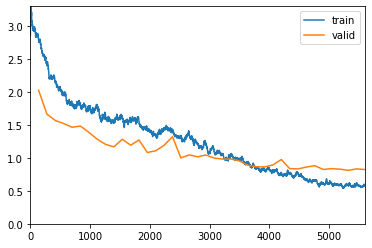

Better model found at epoch 0 with accuracy value: 0.2562277615070343.
Better model found at epoch 1 with accuracy value: 0.3825622797012329.
Better model found at epoch 2 with accuracy value: 0.435943067073822.
Better model found at epoch 3 with accuracy value: 0.517793595790863.
Better model found at epoch 4 with accuracy value: 0.5320284962654114.
Better model found at epoch 5 with accuracy value: 0.5427046418190002.
Better model found at epoch 6 with accuracy value: 0.5444839596748352.
Better model found at epoch 9 with accuracy value: 0.5854092240333557.
Better model found at epoch 17 with accuracy value: 0.6120996475219727.
Better model found at epoch 18 with accuracy value: 0.6174377202987671.
Better model found at epoch 21 with accuracy value: 0.6192170977592468.
Better model found at epoch 22 with accuracy value: 0.626334547996521.
Better model found at epoch 23 with accuracy value: 0.6298932433128357.
Better model found at epoch 24 with accuracy value: 0.6334519386291504.
Bet

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.767195,2.008093,0.724199,0.275801,0.464371,00:14
1,2.456284,1.729227,0.628114,0.371886,0.470508,00:13
2,2.160556,1.517901,0.556939,0.443060,0.469880,00:13
3,1.933230,1.448646,0.505338,0.494662,0.462585,00:13
4,1.836025,1.480938,0.503559,0.496441,0.491033,00:13
5,1.855042,1.393799,0.480427,0.519573,0.470760,00:14
6,1.778970,1.373347,0.505338,0.494662,0.429308,00:14
7,1.613919,1.544458,0.503559,0.496441,0.457328,00:13
8,1.578017,1.195812,0.430605,0.569395,0.441608,00:14
9,1.613002,1.272826,0.482206,0.517794,0.497296,00:13


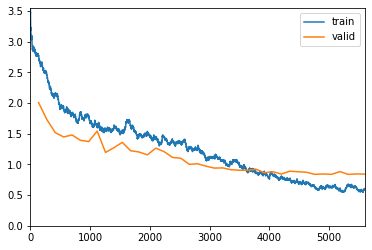

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.37188613414764404.
Better model found at epoch 2 with accuracy value: 0.4430604875087738.
Better model found at epoch 3 with accuracy value: 0.49466192722320557.
Better model found at epoch 4 with accuracy value: 0.4964412748813629.
Better model found at epoch 5 with accuracy value: 0.5195729732513428.
Better model found at epoch 8 with accuracy value: 0.5693950057029724.
Better model found at epoch 13 with accuracy value: 0.5871886014938354.
Better model found at epoch 17 with accuracy value: 0.5889679789543152.
Better model found at epoch 18 with accuracy value: 0.628113865852356.
Better model found at epoch 21 with accuracy value: 0.6405693888664246.
Better model found at epoch 23 with accuracy value: 0.6441280841827393.
Better model found at epoch 25 with accuracy value: 0.6690391302108765.
Better model found at epoch 27 with accuracy value: 0.6850534081459045

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.776525,2.003701,0.724199,0.275801,0.463063,00:14
1,2.471355,1.726921,0.619217,0.380783,0.469854,00:14
2,2.162436,1.549560,0.572954,0.427046,0.446814,00:14
3,1.905971,1.466955,0.514235,0.485765,0.410142,00:14
4,1.802638,1.473464,0.503559,0.496441,0.420806,00:14
5,1.827612,1.366761,0.469751,0.530249,0.426315,00:14
6,1.779835,1.233754,0.435943,0.564057,0.421259,00:14
7,1.644281,1.402815,0.503559,0.496441,0.364464,00:14
8,1.616541,1.299113,0.435943,0.564057,0.595644,00:14
9,1.631744,1.217587,0.487544,0.512456,0.521619,00:14


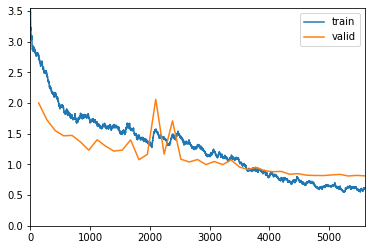

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.38078293204307556.
Better model found at epoch 2 with accuracy value: 0.4270462691783905.
Better model found at epoch 3 with accuracy value: 0.48576512932777405.
Better model found at epoch 4 with accuracy value: 0.4964412748813629.
Better model found at epoch 5 with accuracy value: 0.5302491188049316.
Better model found at epoch 6 with accuracy value: 0.564056932926178.
Better model found at epoch 12 with accuracy value: 0.581850528717041.
Better model found at epoch 18 with accuracy value: 0.5907473564147949.
Better model found at epoch 20 with accuracy value: 0.6067615747451782.
Better model found at epoch 22 with accuracy value: 0.6192170977592468.
Better model found at epoch 25 with accuracy value: 0.6423487663269043.
Better model found at epoch 26 with accuracy value: 0.6530249118804932.
Better model found at epoch 27 with accuracy value: 0.6565836071968079.

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.761997,1.999337,0.736655,0.263345,0.461931,00:13
1,2.339452,1.700905,0.617438,0.382562,0.472495,00:13
2,2.078683,1.565496,0.576512,0.423488,0.490304,00:14
3,1.890069,1.467356,0.503559,0.496441,0.516110,00:14
4,1.873245,1.400651,0.480427,0.519573,0.455039,00:14
5,1.735507,1.427410,0.494662,0.505338,0.484342,00:13
6,1.766792,1.351163,0.460854,0.539146,0.381769,00:14
7,1.693024,1.337759,0.448399,0.551601,0.416606,00:13
8,1.704793,1.363239,0.471530,0.528470,0.501446,00:14
9,1.611586,1.138080,0.421708,0.578292,0.496541,00:14


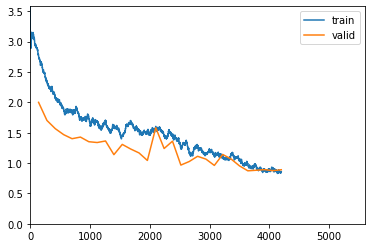

Better model found at epoch 0 with accuracy value: 0.2633451819419861.
Better model found at epoch 1 with accuracy value: 0.3825622797012329.
Better model found at epoch 2 with accuracy value: 0.4234875440597534.
Better model found at epoch 3 with accuracy value: 0.4964412748813629.
Better model found at epoch 4 with accuracy value: 0.5195729732513428.
Better model found at epoch 6 with accuracy value: 0.5391458868980408.
Better model found at epoch 7 with accuracy value: 0.5516014099121094.
Better model found at epoch 9 with accuracy value: 0.5782918334007263.
Better model found at epoch 13 with accuracy value: 0.5925266742706299.
Better model found at epoch 17 with accuracy value: 0.6103202700614929.
Better model found at epoch 21 with accuracy value: 0.6370106935501099.
Better model found at epoch 24 with accuracy value: 0.6387900114059448.
Better model found at epoch 25 with accuracy value: 0.663701057434082.
Better model found at epoch 27 with accuracy value: 0.6672598123550415.
B

In [ ]:
from efficientnet_pytorch import EfficientNet
seeds = [1,2,3,4,5,6,7,8]
epochs = 40
images_folder = 'picked_30_ISIC_2019_Training_Input'

for s in seeds:
    data = reload_dataset(images_folder)
    
    random_seed(1,True)

    learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                                ], pretrained=True)
    learn.unfreeze()
    learn.summary()


    train_learner(learn,'ResNet50',epochs=epochs, seed=s,lr=1.74e-04)
    l1 = list(map(lambda x: x[1], learn.recorder.metrics))
    
    
    
    
    #Con attention
    data = reload_dataset(destFolder)

    r50_attn = models.resnet50(pretrained=True)
    apply_leaf(r50_attn, change_basic_blocks)
    random_seed(1,True)

    learn_attn = cnn_learner(data, lambda x: r50_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                                ], pretrained=True)
    learn_attn.unfreeze()
    learn_attn.summary()
    

    # learn_b0.summary()
    train_learner(learn_attn,'Resnet50-Attn',epochs=epochs, seed=s,lr=1.74e-04)
    
    l2 = list(map(lambda x: x[1], learn_attn.recorder.metrics))
    
    f = open(f'attn_run_seed_{s}.txt','w+')
    f.write('Baseline, With ARL\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

# TODO

Chequear que el final de las arquitecturas sea identico (porahi ponerle lambda x:resnet50 lo cambia)

Conseguir los Alphas para alguna corrida

6.103515625e-05